### Group 28 members:
- Jingze Tian (jingze4)
- Letian Ren (letian2)
- Essam Gouda (egouda)

# Task 2: Classification
- Logistic Regression model for female OR male mosquito = function(weather_features)
- Support Vector Machine model for female OR male mosquito = function(weather_features)
- Random Forest model for female OR male mosquito = function(weather_features)

#### Variations for each model:
- 10-fold cross validation for each model was performed
- ROC curve for each model was plotted

# Imports

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from _datetime import datetime

import matplotlib.pyplot as plt
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white bg for sns plots
sns.set(style="whitegrid", color_codes=True)

import warnings; warnings.simplefilter('ignore')

# Read csv files (datasets)

In [2]:
weather_data = pd.read_csv('./data/weather_data.csv')
mos_data = pd.read_csv('./data/mosquito_data_new.csv')

In [3]:
mos_data.head()

,Trap Date,Genus,Specific Epithet,Gender,IDd,Count,Trap Region,Include,Comparison Group,Latitude,Longitude,Location
0,09/15/2015 12:00:00 AM,Aedes,vexans,Female,NaN,3,Rural-West,NaN,Outer,53.562973,-113.787353,POINT (-113.787353 53.5629733)
1,05/12/1998 12:00:00 AM,Male,UnID,Male,UnID,1,Rural-North West,NaN,Peripheral,53.617221,-113.716182,POINT (-113.716182 53.617221)
2,08/28/2001 12:00:00 AM,Culex,tarsalis,Female,NaN,1,Rural-North West,NaN,Peripheral,53.617221,-113.716182,POINT (-113.716182 53.617221)
3,08/17/2004 12:00:00 AM,Culex,territans,Female,NaN,1,Rural-North West,NaN,Peripheral,53.617221,-113.716182,POINT (-113.716182 53.617221)
4,05/15/2018 12:00:00 AM,Culiseta,impatiens,Female,NaN,2,Rural-West,NaN,Outer,53.559020,-114.001190,POINT (-114.00119 53.559020000000004)


In [4]:
weather_data.head()

,date_time_local,unixtime,pressure_station,pressure_sea,wind_dir,wind_dir_10s,wind_speed,wind_gust,relative_humidity,dew_point,temperature,windchill,humidex,visibility,health_index,cloud_cover_4,cloud_cover_8,cloud_cover_10,solar_radiation
0,2018-12-18 16:00:00 MST,1545174000,91.73,99.7,SW,23.0,5.0,NaN,64.0,-7.3,-1.3,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-12-18 15:00:00 MST,1545170400,91.67,99.7,S,18.0,5.0,NaN,65.0,-6.3,-0.5,-2.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN
2,2018-12-18 14:00:00 MST,1545166800,91.67,99.6,S,17.0,5.0,NaN,51.0,-6.5,2.7,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
3,2018-12-18 13:00:00 MST,1545163200,91.66,99.6,SE,13.0,2.0,NaN,50.0,-6.4,2.9,NaN,NaN,NaN,3.9,NaN,NaN,NaN,NaN
4,2018-12-18 12:00:00 MST,1545159600,91.75,99.7,NaN,NaN,0.0,NaN,59.0,-6.6,0.5,NaN,NaN,NaN,4.1,NaN,NaN,NaN,NaN


In [5]:
first_row = {'Trap Date':['05/09/2017 12:00:00 AM'], 'Gender':'Male', 'Count':0}
first_row = pd.DataFrame(first_row)
mos_data = mos_data.append(first_row)

## Select dates range for mosquito data

In [6]:
t_list = []
for i in mos_data['Trap Date']:
    i = str(i)
    t1 = time.strptime(i,"%m/%d/%Y %H:%M:%S AM")
    t2 = time.strftime("%Y-%m-%d", t1)
    t_list.append(t2)

mos_data['Trap Date'] = t_list


mos_data['Trap Date'] = pd.to_datetime(mos_data['Trap Date'])

############data select#############
start_remove = min(weather_data['date_time_local'])
end_remove = max(weather_data['date_time_local'])
mos_data_1 = mos_data.loc[(mos_data["Trap Date"] >= start_remove) & (mos_data["Trap Date"] <= end_remove) ]
mos_date_start = str(mos_data_1['Trap Date'].dt.date.min())
mos_date_end = str(mos_data_1['Trap Date'].dt.date.max())
mos_date_range = mos_date_start +' to ' + mos_date_end
print("Range of dates in mosquito dataset is {}".format(mos_date_range))

mos_data['Trap Date'] = pd.to_datetime(mos_data['Trap Date'])
mos_range = (mos_data['Trap Date'] >= mos_date_start) & (mos_data['Trap Date'] <= mos_date_end)
mos_data = mos_data.loc[mos_range]
mos_data = mos_data.sort_values(by='Trap Date')


mos_count = mos_data.groupby(["Trap Date"]).agg({
    "Count":"sum",
})
mos_count[mos_count['Count'] == mos_count['Count'].max()]

Range of dates in mosquito dataset is 2017-05-09 to 2018-09-25


,Count
Trap Date,
2018-06-12,9938


In [7]:
mos_data.head()

,Comparison Group,Count,Gender,Genus,IDd,Include,Latitude,Location,Longitude,Specific Epithet,Trap Date,Trap Region
0,NaN,0,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-05-09,NaN
6843,Outer,2,Female,Culiseta,NaN,NaN,53.562973,POINT (-113.787353 53.5629733),-113.787353,inornata,2017-05-09,Rural-West
17781,Peripheral,1,Female,Culiseta,NaN,NaN,53.619232,POINT (-113.7127984 53.6192317),-113.712798,inornata,2017-05-09,Rural-North West
19436,Peripheral,2,Female,Culiseta,NaN,NaN,53.528587,POINT (-113.7380701 53.5285872),-113.738070,alaskaensis,2017-05-09,Rural-South West
16953,Outer,2,Female,Culiseta,NaN,NaN,53.333327,POINT (-113.5313737 53.3333269),-113.531374,inornata,2017-05-09,Outer Community-South1


In [8]:
mos_count.head()

,Count
Trap Date,
2017-05-09,26
2017-05-16,29
2017-05-23,523
2017-05-30,363
2017-06-06,1656


## Select dates range for weather data

In [9]:
start_date1 = '2017-05-03' #one week before 2017-05-09
end_date1 = '2017-09-26'
start_date2 = '2018-05-09' #one week before 2018-05-15
end_date2 = '2018-09-25'

##############Drop MST###################
weather_data.drop(columns=["visibility", "cloud_cover_4", "cloud_cover_8", "cloud_cover_10", "solar_radiation", "wind_gust", "windchill", "humidex"], inplace=True)
weather_data = weather_data.loc[weather_data['date_time_local'].str.contains('MDT')]


t_list = []
for i in weather_data['date_time_local']:
    i = str(i)
    t1 = time.strptime(i,"%Y-%m-%d %H:%M:%S MDT")
    t2 = time.strftime("%Y-%m-%d", t1)
    t_list.append(t2)

weather_data['date_time_local'] = t_list


weather_data['date_time_local'] = pd.to_datetime(weather_data['date_time_local'])
weather_range1 = (weather_data['date_time_local'] >= start_date1) & (weather_data['date_time_local'] <= end_date1)
weather_data1 = weather_data.loc[weather_range1]
weather_data1 = weather_data1.sort_values(by='date_time_local')


weather_range2 = (weather_data['date_time_local'] >= start_date2) & (weather_data['date_time_local'] <= end_date2)
weather_data2 = weather_data.loc[weather_range2]
weather_data2 = weather_data2.sort_values(by='date_time_local')
weather_data = weather_data1.append(weather_data2)

In [10]:
weather_data.head()

,date_time_local,unixtime,pressure_station,pressure_sea,wind_dir,wind_dir_10s,wind_speed,relative_humidity,dew_point,temperature,health_index
14273,2017-05-03,1493791200,93.91,101.9,SW,21.0,3.0,64.0,0.3,6.6,3.0
14250,2017-05-03,1493874000,93.51,101.4,SW,22.0,7.0,50.0,2.6,12.7,3.7
14251,2017-05-03,1493870400,93.49,101.4,SW,24.0,6.0,48.0,2.0,12.9,3.5
14252,2017-05-03,1493866800,93.44,101.3,WNW,29.0,5.0,34.0,1.0,17.1,3.3
14253,2017-05-03,1493863200,93.38,101.3,W,27.0,7.0,28.0,0.2,18.9,3.3


## Seperate mosquito data by gender

In [11]:
mos_data_male = mos_data.loc[mos_data['Gender'].str.contains('Male')]
mos_data_female = mos_data.loc[mos_data['Gender'].str.contains('Female')]

mos_count_male = mos_data_male.groupby(["Trap Date"]).agg({
    "Count":"sum",
})
mos_count_male[mos_count_male['Count'] == mos_count_male['Count'].max()]


mos_count_female = mos_data_female.groupby(["Trap Date"]).agg({
    "Count":"sum",
})
mos_count_female[mos_count_female['Count'] == mos_count_female['Count'].max()]


mos_count_male["Count_female"] = mos_count_female["Count"]
mos_count_male['Gender'] = np.where(mos_count_male["Count"] > mos_count_male["Count_female"], 'Male', 'Female')
#compare count

gender = np.array(mos_count_male['Gender'])

## Grouping both datasets
- For justifications for the methods of grouping the weather data please refer to task 1

#### weather data grouping by days then weekly

In [12]:
weather_data_grouped = weather_data.groupby('date_time_local', as_index=False).agg({
    'pressure_station': lambda x: x.value_counts().index[0],
    'pressure_sea': lambda x: x.median(),
    'wind_dir_10s': lambda x: x.value_counts().index[0],
    'wind_speed': lambda x: x.value_counts().index[0],
    'dew_point': lambda x: x.value_counts().index[0],
    'temperature': lambda x: x.value_counts().index[0],
    'health_index': lambda x: round(x.mean(), 1)
})

print(len(weather_data_grouped.index))

287


In [13]:
weather_data_grouped.sort_values('date_time_local', inplace=True)
weather_data_grouped.head(7)

,date_time_local,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index
0,2017-05-03,93.87,101.50,20.0,7.0,-1.6,18.9,2.8
1,2017-05-04,93.64,101.40,22.0,7.0,1.9,8.4,3.2
2,2017-05-05,92.13,100.25,15.0,13.0,4.6,27.2,2.8
3,2017-05-06,92.68,100.30,28.0,13.0,5.2,14.9,2.4
4,2017-05-07,93.48,101.30,31.0,18.0,-3.0,6.3,2.2
5,2017-05-08,93.54,101.60,31.0,8.0,-4.8,14.0,2.9
6,2017-05-09,93.62,101.60,32.0,7.0,2.1,16.7,2.9


In [14]:
weather_data_grouped = weather_data_grouped.groupby(weather_data_grouped.index // 7).agg({
    'date_time_local': 'last',
    'pressure_station': lambda x: x.value_counts().index[0],
    'pressure_sea': lambda x: x.median(),
    'wind_dir_10s': lambda x: x.value_counts().index[0],
    'wind_speed': lambda x: x.value_counts().index[0],
    'dew_point': lambda x: x.value_counts().index[0],
    'temperature': lambda x: x.value_counts().index[0],
    'health_index': lambda x: round(x.mean(), 1)
})

print(len(weather_data_grouped.index))

## NOTE GROUPING DATA BY WEEK LED TO LOWER ACCURACY

41


#### mosquito data grouping by date

In [15]:
mos_data.head()

,Comparison Group,Count,Gender,Genus,IDd,Include,Latitude,Location,Longitude,Specific Epithet,Trap Date,Trap Region
0,NaN,0,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-05-09,NaN
6843,Outer,2,Female,Culiseta,NaN,NaN,53.562973,POINT (-113.787353 53.5629733),-113.787353,inornata,2017-05-09,Rural-West
17781,Peripheral,1,Female,Culiseta,NaN,NaN,53.619232,POINT (-113.7127984 53.6192317),-113.712798,inornata,2017-05-09,Rural-North West
19436,Peripheral,2,Female,Culiseta,NaN,NaN,53.528587,POINT (-113.7380701 53.5285872),-113.738070,alaskaensis,2017-05-09,Rural-South West
16953,Outer,2,Female,Culiseta,NaN,NaN,53.333327,POINT (-113.5313737 53.3333269),-113.531374,inornata,2017-05-09,Outer Community-South1


In [16]:
idx = mos_data.groupby(['Trap Date'])['Count'].transform(max) == mos_data['Count']

mos_data_grouped = mos_data[idx]
mos_data_grouped.drop(columns=['IDd', 'Include', 'Latitude', 'Location', 'Longitude','Trap Region'], inplace=True)
mos_data_grouped.head()

,Comparison Group,Count,Gender,Genus,Specific Epithet,Trap Date
19777,Peripheral,3,Female,Culiseta,inornata,2017-05-09
13603,Core,3,Female,Culiseta,inornata,2017-05-09
11069,Core,3,Female,Culiseta,inornata,2017-05-09
19195,Core,13,Female,Ochlerotatus,Black legs,2017-05-16
16171,Outer,137,Male,Male,UnID,2017-05-23


In [17]:
len(mos_data_grouped)

43

#### merging both dataset by date

In [18]:
merged_data = pd.merge(left=mos_data_grouped, right=weather_data_grouped, left_on='Trap Date', right_on='date_time_local')
merged_data.drop(columns=['date_time_local'], inplace=True)

In [19]:
merged_data.head()

,Comparison Group,Count,Gender,Genus,Specific Epithet,Trap Date,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index
0,Peripheral,3,Female,Culiseta,inornata,2017-05-09,93.87,101.4,31.0,7.0,5.2,6.3,2.7
1,Core,3,Female,Culiseta,inornata,2017-05-09,93.87,101.4,31.0,7.0,5.2,6.3,2.7
2,Core,3,Female,Culiseta,inornata,2017-05-09,93.87,101.4,31.0,7.0,5.2,6.3,2.7
3,Core,13,Female,Ochlerotatus,Black legs,2017-05-16,92.94,100.9,11.0,12.0,5.3,2.4,2.4
4,Outer,137,Male,Male,UnID,2017-05-23,92.37,101.9,20.0,6.0,5.1,22.9,2.5


In [20]:
merged_data.drop(columns=['Count'], inplace=True)
merged_data.head()

,Comparison Group,Gender,Genus,Specific Epithet,Trap Date,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index
0,Peripheral,Female,Culiseta,inornata,2017-05-09,93.87,101.4,31.0,7.0,5.2,6.3,2.7
1,Core,Female,Culiseta,inornata,2017-05-09,93.87,101.4,31.0,7.0,5.2,6.3,2.7
2,Core,Female,Culiseta,inornata,2017-05-09,93.87,101.4,31.0,7.0,5.2,6.3,2.7
3,Core,Female,Ochlerotatus,Black legs,2017-05-16,92.94,100.9,11.0,12.0,5.3,2.4,2.4
4,Outer,Male,Male,UnID,2017-05-23,92.37,101.9,20.0,6.0,5.1,22.9,2.5


In [21]:
len(merged_data)

43

In [22]:
merged_data.isnull().sum()

Comparison Group    0
Gender              0
Genus               0
Specific Epithet    0
Trap Date           0
pressure_station    0
pressure_sea        0
wind_dir_10s        0
wind_speed          0
dew_point           0
temperature         0
health_index        0
dtype: int64

In [23]:
merged_data['Gender'].value_counts()

Male      22
Female    21
Name: Gender, dtype: int64

It can be seen that the dataset is balanced.

## ADDING EXTRA FEATURES

isWarm feature if the temperature is more than 20 degrees

In [24]:
merged_data['isWarm'] = np.where(merged_data['temperature'] >= 20, 1, 0)

isWindy feature if the windspeed is more than 25 mph

In [25]:
merged_data['isWindy'] = np.where(merged_data['wind_speed'] >= 25, 1, 0)

Categorize Genus and Specific Epither columns

In [26]:
merged_data['Genus'] = merged_data['Genus'].astype('category')
merged_data['genusCat'] = merged_data['Genus'].cat.codes

In [27]:
merged_data['Specific Epithet'] = merged_data['Specific Epithet'].astype('category')
merged_data['epithetCat'] = merged_data['Specific Epithet'].cat.codes

In [28]:
merged_data['Comparison Group'] = merged_data['Comparison Group'].astype('category')
merged_data['compCat'] = merged_data['Comparison Group'].cat.codes

In [29]:
merged_data['genderCat'] = np.where(merged_data['Gender'] == "Female", 1, 0)

delta_pressure is the difference between the station level pressure and the sea level pressure

In [30]:
merged_data["delta_pressure"] = merged_data.apply(lambda x: x['pressure_station'] - x['pressure_sea'], axis=1)

## Correlations matrix

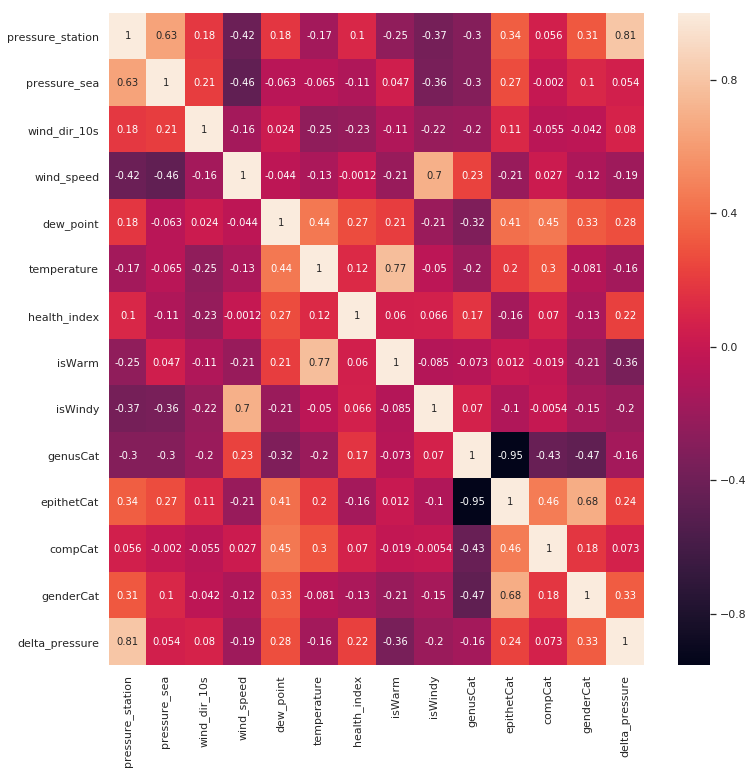

In [31]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(merged_data.corr(), annot=True, ax=ax)

The most positive and the most negative correlation values are picked as features (with genderCat column) as they are the features that have most correlations either positively and negatively and will lead to more patterns in the models.

# Classification

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

Selecting the most correlated features

In [33]:
x_cols = ['delta_pressure', 'epithetCat', 'genusCat', 'isWindy', 'isWarm', 'health_index', 'dew_point', 'wind_speed', 'pressure_sea', 'pressure_station', 'compCat']

X = merged_data[x_cols]
y = merged_data['genderCat']

#### Pipelines
 
2 pipelines are created one for polynomial features and the other for linear features

In [34]:
def PolyPipe(degree, clf):
    poly_features = PolynomialFeatures(degree=degree)

    pipeline = Pipeline([
        ("polynomial_features", poly_features),
        ("classifier", clf)
    ])
    
    return pipeline

def RegularPipe(clf):
    pipeline = Pipeline([
        ("classifier", clf)
    ])
    
    return pipeline


#### Confusion matrix print
Print data from calculating confusion matrix

In [35]:
def cm_print(model, X, y):
    model.fit(X, y)
    Yp = model.predict(X)
    cm = confusion_matrix(y, Yp)
    print(pd.DataFrame(cm))
    tn, fp, fn, tp = cm.flatten()
    tot = np.sum(cm)
    print("Misclassified:",(fn+fp)/tot)
    print("% of error of true No:",fn/(fn+tn)*100)
    print("% of error of true Yes:",fp/(fp+tp)*100)

#### plotting roc

In [36]:
def plot_roc(X,y, pipeline):
    clf = pipeline.fit(X, y)
    Yprob = clf.predict_proba(X)
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y, Yprob[:,1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

# Models & Evaluation

The models follow a pipeline by creating a piepline for each model using linear features and polynomial ones, models used are:

- Logistic regression without regularization (lbfgs solver)
- Logistic regression with L2 regularization (liblinear solver for small datasets)
- Logistic regression with L1 regularization (liblinear solver for small datasets)
- Polynomial Logistic regression without regularization (lbfgs solver)
- Polynomial Logistic regression with L2 regularization (liblinear solver for small datasets)
- Polynomial Logistic regression with L2 regularization (liblinear solver for small datasets)
- SVM with linear kernal
- SVM with rbf kernal
- Random forest

LR_no_pen Accuracy average (std): 0.880000 (0.120830)
    0   1
0  22   0
1   3  18
Misclassified: 0.06976744186046512
% of error of true No: 12.0
% of error of true Yes: 0.0


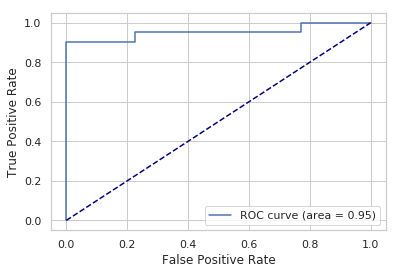



LR_l2 Accuracy average (std): 0.880000 (0.120830)
    0   1
0  22   0
1   3  18
Misclassified: 0.06976744186046512
% of error of true No: 12.0
% of error of true Yes: 0.0


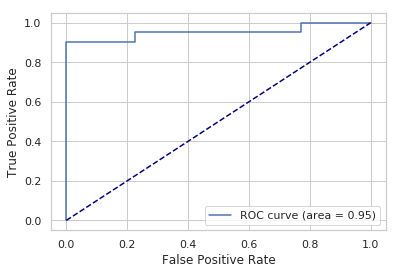



LR_l1 Accuracy average (std): 0.955000 (0.090692)
    0   1
0  22   0
1   1  20
Misclassified: 0.023255813953488372
% of error of true No: 4.3478260869565215
% of error of true Yes: 0.0


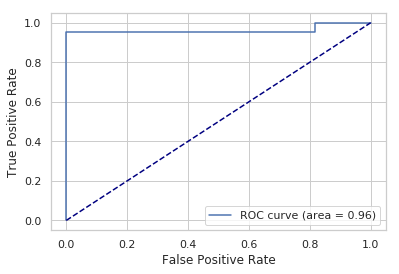



P_LR_no_pen Accuracy average (std): 0.840000 (0.178606)
    0   1
0  22   0
1   0  21
Misclassified: 0.0
% of error of true No: 0.0
% of error of true Yes: 0.0


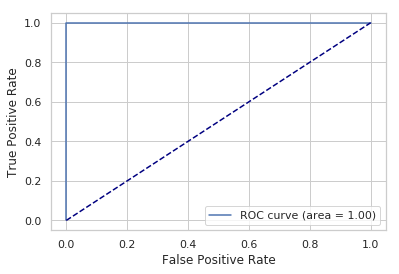



P_LR_l2 Accuracy average (std): 0.980000 (0.060000)
    0   1
0  22   0
1   0  21
Misclassified: 0.0
% of error of true No: 0.0
% of error of true Yes: 0.0


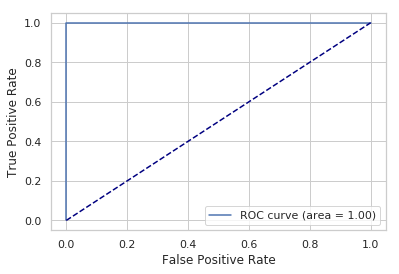



P_LR_l1 Accuracy average (std): 0.980000 (0.060000)
    0   1
0  22   0
1   0  21
Misclassified: 0.0
% of error of true No: 0.0
% of error of true Yes: 0.0


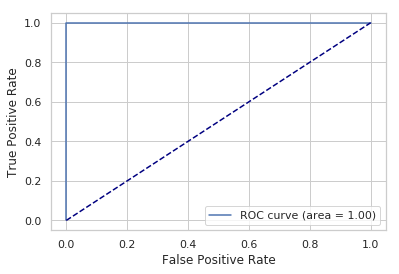



SVM_linear Accuracy average (std): 0.935000 (0.134257)
    0   1
0  22   0
1   1  20
Misclassified: 0.023255813953488372
% of error of true No: 4.3478260869565215
% of error of true Yes: 0.0


SVM_rbf Accuracy average (std): 0.695000 (0.230705)
    0   1
0  22   0
1   2  19
Misclassified: 0.046511627906976744
% of error of true No: 8.333333333333332
% of error of true Yes: 0.0


RF Accuracy average (std): 0.905000 (0.161941)
    0   1
0  22   0
1   1  20
Misclassified: 0.023255813953488372
% of error of true No: 4.3478260869565215
% of error of true Yes: 0.0


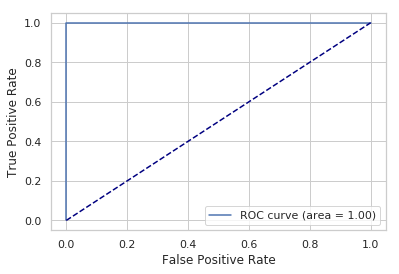



BC Accuracy average (std): 1.000000 (0.000000)
    0   1
0  22   0
1   0  21
Misclassified: 0.0
% of error of true No: 0.0
% of error of true Yes: 0.0


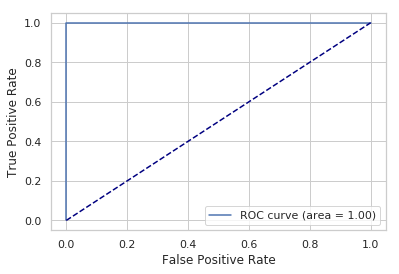



AB Accuracy average (std): 1.000000 (0.000000)
    0   1
0  22   0
1   0  21
Misclassified: 0.0
% of error of true No: 0.0
% of error of true Yes: 0.0


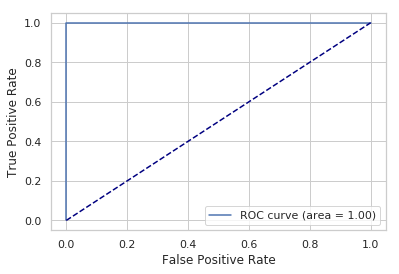



GB Accuracy average (std): 1.000000 (0.000000)
    0   1
0  22   0
1   0  21
Misclassified: 0.0
% of error of true No: 0.0
% of error of true Yes: 0.0


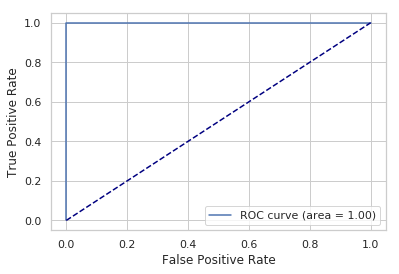

In [38]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


tree = DecisionTreeClassifier()

# prepare configuration for cross validation test harness
seed = 7

models = []

models.append(('LR_no_pen', linear_model.LogisticRegression(solver='lbfgs',multi_class='auto')))
models.append(('LR_l2', linear_model.LogisticRegression(solver='liblinear',multi_class='auto', penalty="l2")))
models.append(('LR_l1', linear_model.LogisticRegression(solver='liblinear',multi_class='auto', penalty="l1")))
models.append(('P_LR_no_pen', linear_model.LogisticRegression(solver='lbfgs',multi_class='auto')))
models.append(('P_LR_l2', linear_model.LogisticRegression(solver='liblinear',multi_class='auto', penalty="l2")))
models.append(('P_LR_l1', linear_model.LogisticRegression(solver='liblinear',multi_class='auto', penalty="l1")))
models.append(('SVM_linear', SVC(kernel='linear')))
models.append(('SVM_rbf', SVC(kernel='rbf')))
models.append(('RF', RandomForestClassifier(n_estimators=10, random_state=0, max_depth=12)))
models.append(('BC', BaggingClassifier(tree, n_estimators=10, max_samples=0.8, random_state=1) ))
models.append(('AB', AdaBoostClassifier(n_estimators=10, base_estimator=tree, learning_rate=1)))
models.append(('GB', GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=1)))



# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    if name.split("_")[0] == 'P':
        clf = PolyPipe(3, model)
    else:
        clf = RegularPipe(model)
    cv_results = model_selection.cross_val_score(clf, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s Accuracy average (std): %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    cm_print(clf, X, y)
    if name.split("_")[0] == "SVM":
        print("\n")
        continue
    plot_roc(X,y, clf)
    print('\n')

### 10-fold cross validation results plot

Due to the dataset being very small when we train on the whole dataset most models overfit that's why the results from the confusion matrix is used.

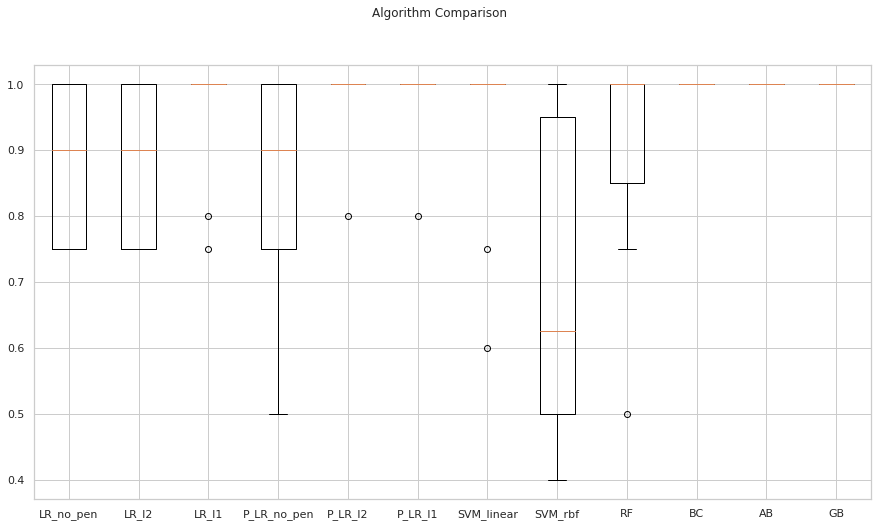

In [39]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(15, 8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Conclusion
Performing t-test or ANOVA would be redundent as we can see from the chart above that BaggingClassifier, AdaBoostClassifier, GradientBoosting classifier are the best models, and Logistic regression with linear features and L1 regularization does have also good results on 10-fold cross validation. But due to the small size of the dataset the trees models might have overfitted